/var/folders/ly/0h90q9c52glg2yt8wr4tc23m0000gn/T/ipykernel_15177/501862444.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').ffill()


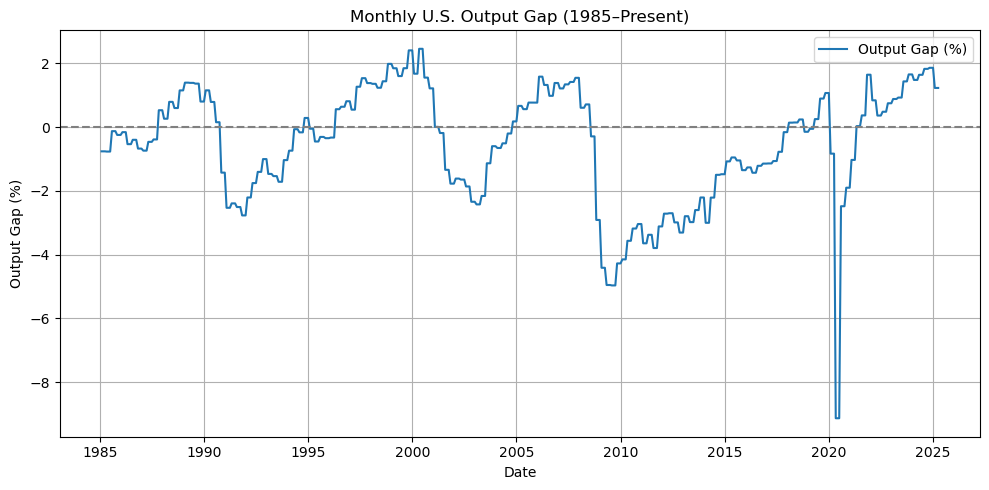

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr


start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)      
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)  

df = pd.concat([actual_gdp, potential_gdp], axis=1)
df.columns = ['Actual_GDP', 'Potential_GDP']

df['Output_Gap'] = 100 * (df['Actual_GDP'] - df['Potential_GDP']) / df['Potential_GDP']
df_monthly = df.resample('M').ffill()
df_monthly = df_monthly.loc['1985-01-01':]

plt.figure(figsize=(10, 5))
plt.plot(df_monthly.index, df_monthly['Output_Gap'], label='Output Gap (%)')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Monthly U.S. Output Gap (1985–Present)')
plt.ylabel('Output Gap (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
df_monthly

,Actual_GDP,Potential_GDP,Output_Gap
DATE,,,
1985-01-31,8400.820,8465.293021,-0.761616
1985-02-28,8400.820,8465.293021,-0.761616
1985-03-31,8400.820,8465.293021,-0.761616
1985-04-30,8474.787,8540.419380,-0.768491
1985-05-31,8474.787,8540.419380,-0.768491
...,...,...,...
2024-12-31,23542.349,23113.340000,1.856110
2025-01-31,23528.047,23243.220000,1.225420
2025-02-28,23528.047,23243.220000,1.225420


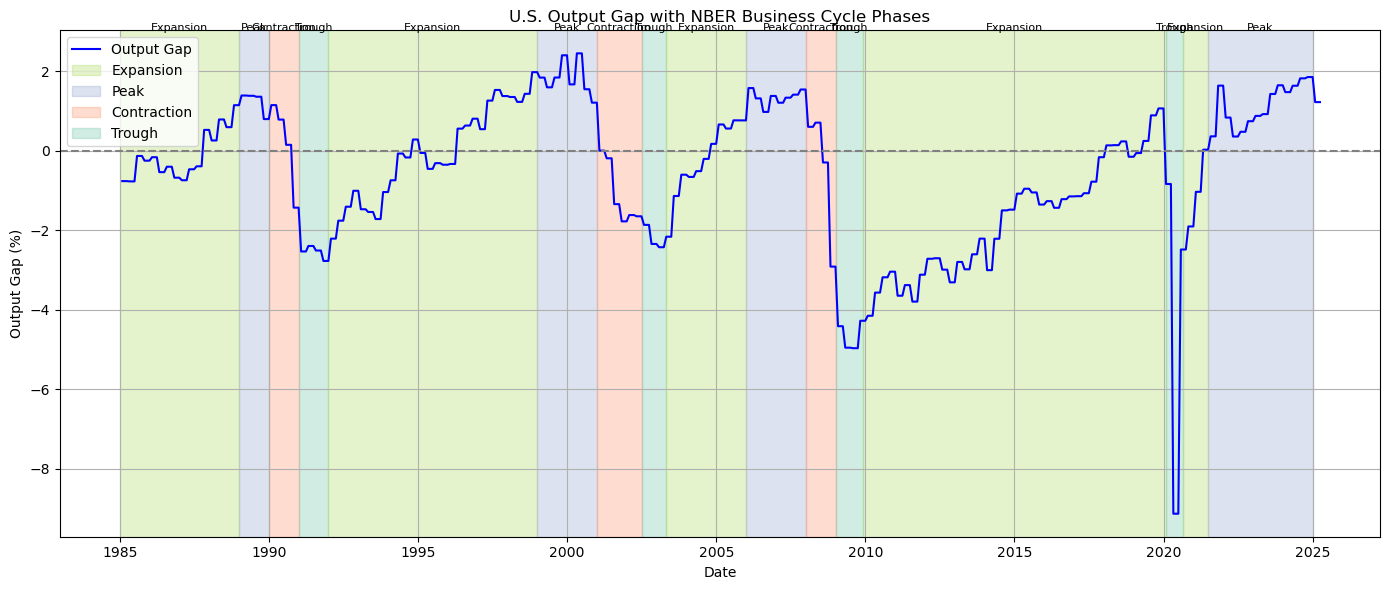

In [6]:
plt.figure(figsize=(14, 6))
plt.plot(df_monthly.index, df_monthly["Output_Gap"], label="Output Gap", color="blue")
plt.axhline(0, color="gray", linestyle="--")
nber_cycles = [
    ("1985-01", "1989-01", "Expansion"),
    ("1989-01", "1990-01", "Peak"),
    ("1990-01", "1991-01", "Contraction"),
    ("1991-01", "1992-01", "Trough"),

    ("1992-01", "1999-01", "Expansion"),
    ("1999-01", "2001-01", "Peak"),
    ("2001-01", "2002-07", "Contraction"),
    ("2002-07", "2003-05", "Trough"),

    ("2003-05", "2006-01", "Expansion"),
    ("2006-01", "2008-01", "Peak"),
    ("2008-01", "2009-01", "Contraction"),
    ("2009-01", "2009-12", "Trough"),
    
    ("2009-12", "2020-02", "Expansion"),
    ("2020-02", "2020-09", "Trough"),
    ("2020-09", "2021-07", "Expansion"),
    ("2021-07", "2025-01", "Peak"),

]
cycle_colors = {
    "Expansion": "#a6d854",
    "Contraction": "#fc8d62",
    "Peak": "#8da0cb",
    "Trough": "#66c2a5" 
}

for start, end, label in nber_cycles:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    plt.axvspan(start_date, end_date, color=cycle_colors[label], alpha=0.3,
                label=label if plt.gca().get_legend_handles_labels()[1].count(label) == 0 else None)
    plt.text((start_date + (end_date - start_date) / 2), df_monthly["Output_Gap"].max() + 0.5,
             label, ha="center", va="bottom", fontsize=8)

plt.title("U.S. Output Gap with NBER Business Cycle Phases")
plt.xlabel("Date")
plt.ylabel("Output Gap (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
from collections import defaultdict

# === Step 1: Load EPS data ===

df_eps = pd.read_excel("Top_20_US_Companies_EPS.xlsx")
df_eps['Date'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(df_eps['Dates'], unit='D')
df_eps = df_eps.drop(columns='Dates').set_index('Date')

# === Step 2: Load sector mapping ===
df_sector = pd.read_excel("Top_20_US_Companies_By_Sector_With_Bloomberg_Tickers.xlsx")
ticker_to_sector = dict(zip(df_sector['Bloomberg_Ticker'], df_sector['Sector']))

# === Step 3: Define business cycle phases ===
business_cycles = [
    ("1985-01", "1989-01", "Expansion"),
    ("1989-01", "1990-01", "Peak"),
    ("1990-01", "1991-01", "Contraction"),
    ("1991-01", "1992-01", "Trough"),
    ("1992-01", "1999-01", "Expansion"),
    ("1999-01", "2001-01", "Peak"),
    ("2001-01", "2002-07", "Contraction"),
    ("2002-07", "2003-03", "Trough"),
    ("2003-03", "2006-01", "Expansion"),
    ("2006-01", "2008-01", "Peak"),
    ("2008-01", "2009-01", "Contraction"),
    ("2009-01", "2009-12", "Trough"),
    ("2009-12", "2020-02", "Expansion"),
    ("2020-02", "2020-09", "Trough"),
    ("2020-09", "2021-07", "Expansion"),
    ("2021-07", "2025-01", "Peak"),
]

# === Step 4: Group periods by phase ===
phase_periods = defaultdict(list)
for start, end, phase in business_cycles:
    phase_periods[phase].append((pd.to_datetime(start), pd.to_datetime(end)))

# === Step 5: Compute average EPS for each sector and cycle phase ===
final_results = []

for phase, periods in phase_periods.items():
    # Merge time periods within the same phase
    df_phase = pd.DataFrame()
    for start_date, end_date in periods:
        df_slice = df_eps[(df_eps.index >= start_date) & (df_eps.index < end_date)]
        df_phase = pd.concat([df_phase, df_slice])

    # Calculate sector-level average EPS
    sector_eps = defaultdict(list)
    for ticker in df_phase.columns:
        sector = ticker_to_sector.get(ticker)
        if sector:
            sector_eps[sector].append(df_phase[ticker])

    for sector, eps_series in sector_eps.items():
        combined = pd.concat(eps_series, axis=1)
        avg_eps = combined.mean(axis=1, skipna=True).mean(skipna=True)
        if pd.notna(avg_eps):
            final_results.append({
                "Sector": sector,
                "Cycle_Phase": phase,
                "Average_EPS": avg_eps
            })

# === Step 6: Save or print results ===
df_result = pd.DataFrame(final_results)
print(df_result)
# df_result.to_excel("Sector_EPS_by_Cycle.xlsx", index=False)

                    Sector  Cycle_Phase  Average_EPS
0   Information Technology    Expansion     0.377949
1              Health Care    Expansion     0.725625
2               Financials    Expansion     1.337286
3   Communication Services    Expansion     0.146357
4   Consumer Discretionary    Expansion     1.063776
5         Consumer Staples    Expansion     0.543520
6                   Energy    Expansion     0.403222
7              Industrials    Expansion     0.907293
8                Materials    Expansion     0.621465
9              Real Estate    Expansion     0.417614
10               Utilities    Expansion     0.474361
11  Information Technology         Peak     0.722737
12             Health Care         Peak     1.364802
13              Financials         Peak     2.395394
14  Communication Services         Peak     0.222839
15  Consumer Discretionary         Peak     2.445370
16        Consumer Staples         Peak     0.711067
17                  Energy         Peak     1.

In [12]:
# Step 1: 聚合（防止重复组合）
df_cleaned = df_result.groupby(["Sector", "Cycle_Phase"]).mean(numeric_only=True).reset_index()

# Step 2: Pivot 成行业 × 周期的结构
df_pivot = df_cleaned.pivot(index="Sector", columns="Cycle_Phase", values="Average_EPS")

# Step 3: 按你希望的顺序排列列
df_pivot = df_pivot[["Expansion", "Peak", "Contraction", "Trough"]]

# Step 4: 输出结果（可视化或保存）
print(df_pivot)

Cycle_Phase             Expansion      Peak  Contraction    Trough
Sector                                                            
Communication Services   0.146357  0.222839    -0.864942 -0.077588
Consumer Discretionary   1.063776  2.445370     0.170262  1.733276
Consumer Staples         0.543520  0.711067     0.335613  0.409108
Energy                   0.403222  1.501020     0.381152 -0.439363
Financials               1.337286  2.395394    -2.107126  0.747365
Health Care              0.725625  1.364802     0.253083  0.589745
Industrials              0.907293  1.483599     0.425254  0.461442
Information Technology   0.377949  0.722737     0.118438  0.187876
Materials                0.621465  0.913508     0.283431  0.372082
Real Estate              0.417614  0.649510     0.250533  0.401601
Utilities                0.474361  0.618444     0.399680  0.394564


In [14]:
# 设置时间区间
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# === 1. M2 YoY 增速 ===
m2 = pdr.DataReader('M2SL', 'fred', start_date, end_date)
m2_yoy = m2.pct_change(periods=12) * 100
m2_yoy.rename(columns={'M2SL': 'M2_YoY'}, inplace=True)

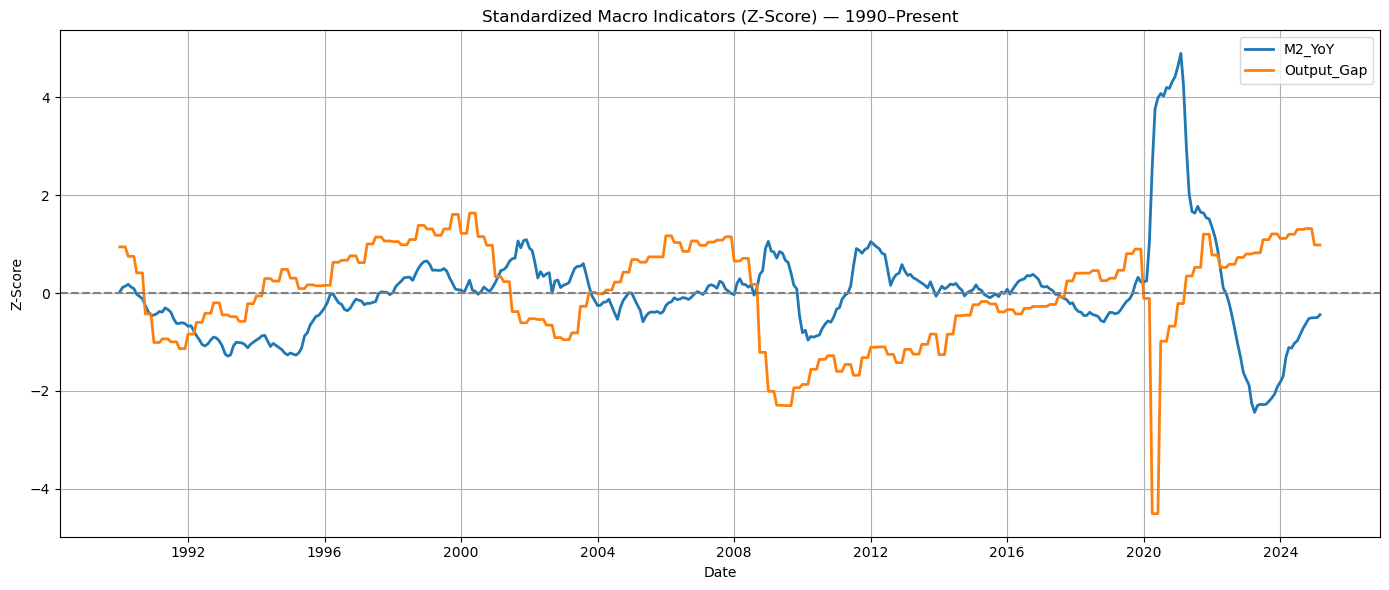

In [16]:
m2_yoy.index = m2_yoy.index.to_period('M').to_timestamp()
df_monthly.index = df_monthly.index.to_period('M').to_timestamp()  # 你原来的 Output Gap

df_all = pd.concat([
    m2_yoy,
    df_monthly[['Output_Gap']]
], axis=1)

df_all = df_all.loc['1990-01-01':]

df_clean = df_all.dropna()
df_standardized = (df_clean - df_clean.mean()) / df_clean.std()

plt.figure(figsize=(14, 6))
for col in df_standardized.columns:
    plt.plot(df_standardized.index, df_standardized[col], label=col, linewidth=2)

plt.title("Standardized Macro Indicators (Z-Score) — 1990–Present")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.axhline(0, linestyle='--', color='gray')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

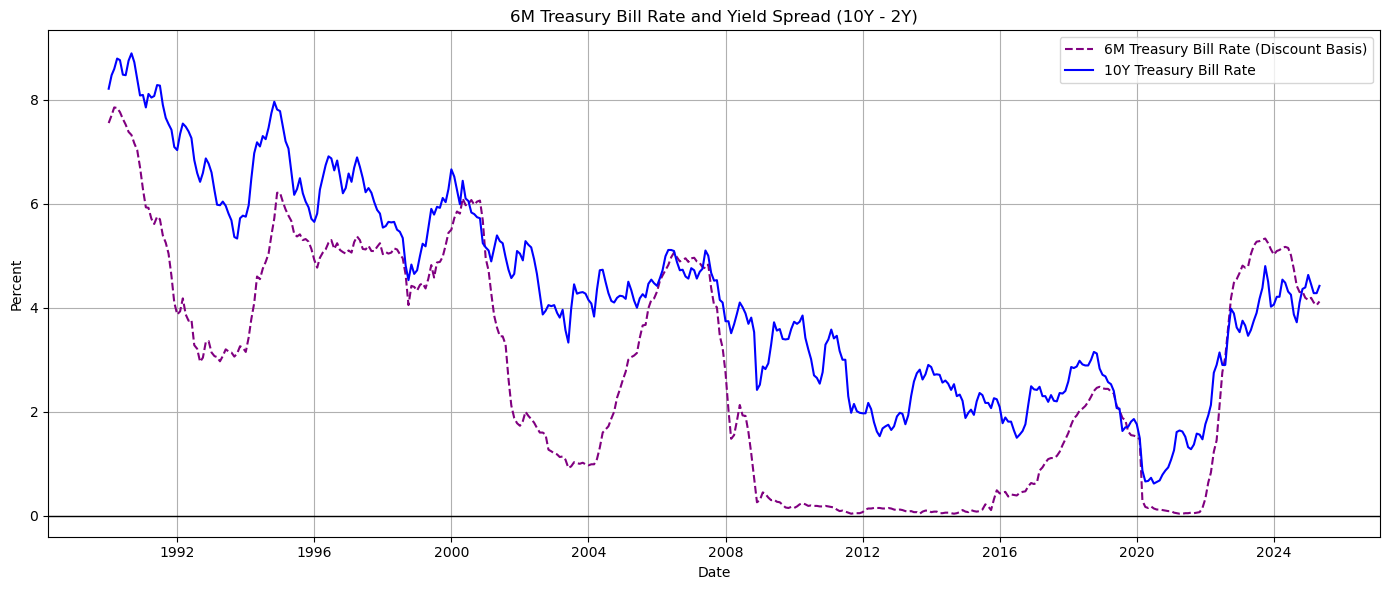

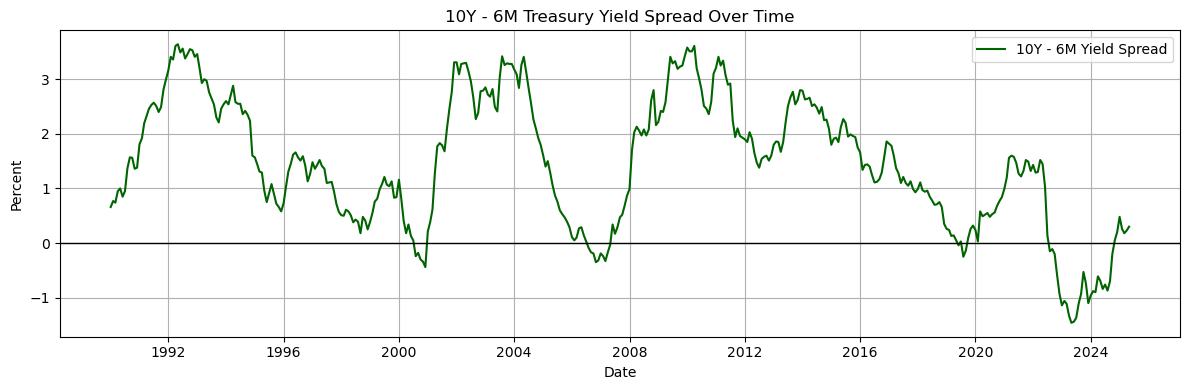

In [20]:
df_tb = pd.read_csv("fredgraph.csv")

df_tb.columns = df_tb.columns.str.strip()
df_tb = df_tb.rename(columns={
    'observation_date': 'Date',
    'DGS10': 'TBill_10Y',
    'DTB6': 'TBill_6M'
})


df_tb['Date'] = pd.to_datetime(df_tb['Date'])

df_tb['10Y_minus_6M'] = df_tb['TBill_10Y'] - df_tb['TBill_6M']

df_tb['Date'] = pd.to_datetime(df_tb['Date'])
#figure 1
plt.figure(figsize=(14, 6))
plt.plot(df_tb['Date'], df_tb['TBill_6M'], label='6M Treasury Bill Rate (Discount Basis)', linestyle='--', color='purple')
plt.plot(df_tb['Date'], df_tb['TBill_10Y'], label='10Y Treasury Bill Rate', color='blue')
plt.axhline(0, color='black', linewidth=1)
plt.title("6M Treasury Bill Rate and Yield Spread (10Y - 2Y)")
plt.ylabel("Percent")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
#figure2
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(df_tb['Date'], df_tb['10Y_minus_6M'], label='10Y - 6M Yield Spread', color='darkgreen')
plt.axhline(0, color='black', linewidth=1)
plt.title("10Y - 6M Treasury Yield Spread Over Time")
plt.xlabel("Date")
plt.ylabel("Percent")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

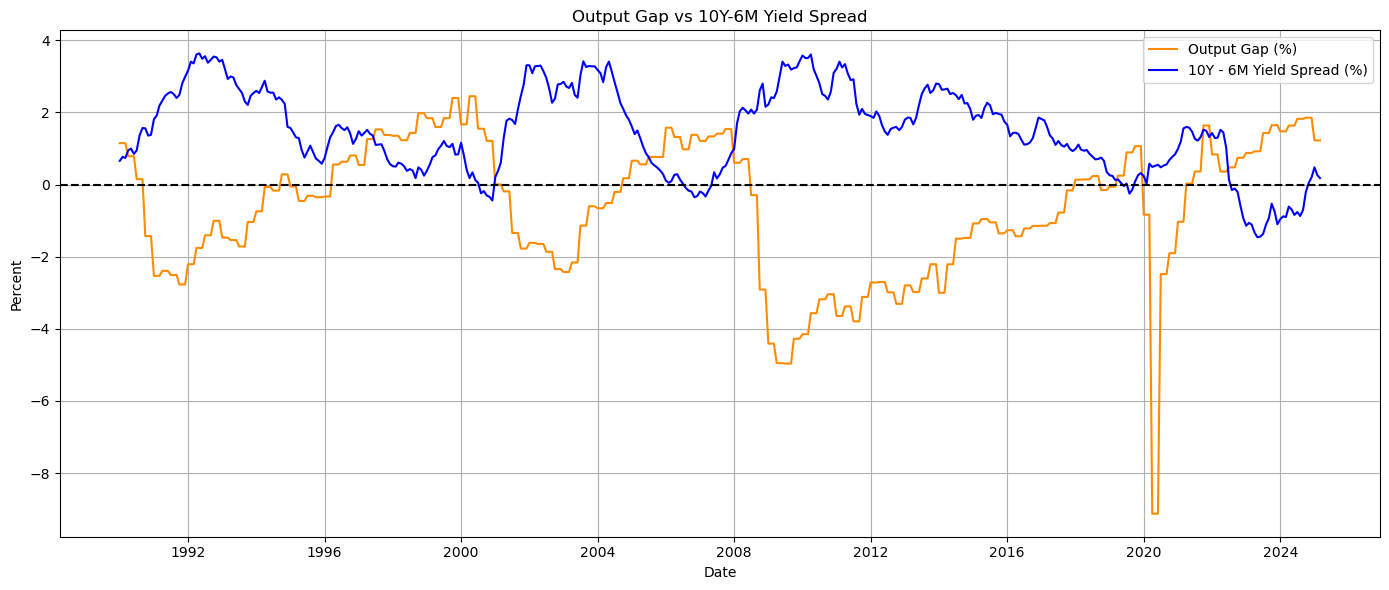

In [22]:

df_tb['Date'] = pd.to_datetime(df_tb['Date'])
df_tb = df_tb.set_index('Date')
df_plot = pd.concat([df_monthly[['Output_Gap']], df_tb[['10Y_minus_6M']]], axis=1)
df_plot = df_plot.dropna()

# plot
plt.figure(figsize=(14, 6))
plt.plot(df_plot.index, df_plot['Output_Gap'], label='Output Gap (%)', color='darkorange')
plt.plot(df_plot.index, df_plot['10Y_minus_6M'], label='10Y - 6M Yield Spread (%)', color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.title("Output Gap vs 10Y-6M Yield Spread")
plt.xlabel("Date")
plt.ylabel("Percent")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
df_tb['10Y_minus_6M_lag1'] = df_tb['10Y_minus_6M'].shift(1)
df_all['M2_YoY_lag1'] = df_all['M2_YoY'].shift(1)
df_all = df_all.merge(
    df_tb[['10Y_minus_6M', '10Y_minus_6M_lag1']],
    left_index=True, right_index=True, how='left'
)

[[ 50   3]
 [  0 114]]
              precision    recall  f1-score   support

           0      1.000     0.943     0.971        53
           1      0.974     1.000     0.987       114

    accuracy                          0.982       167
   macro avg      0.987     0.972     0.979       167
weighted avg      0.982     0.982     0.982       167



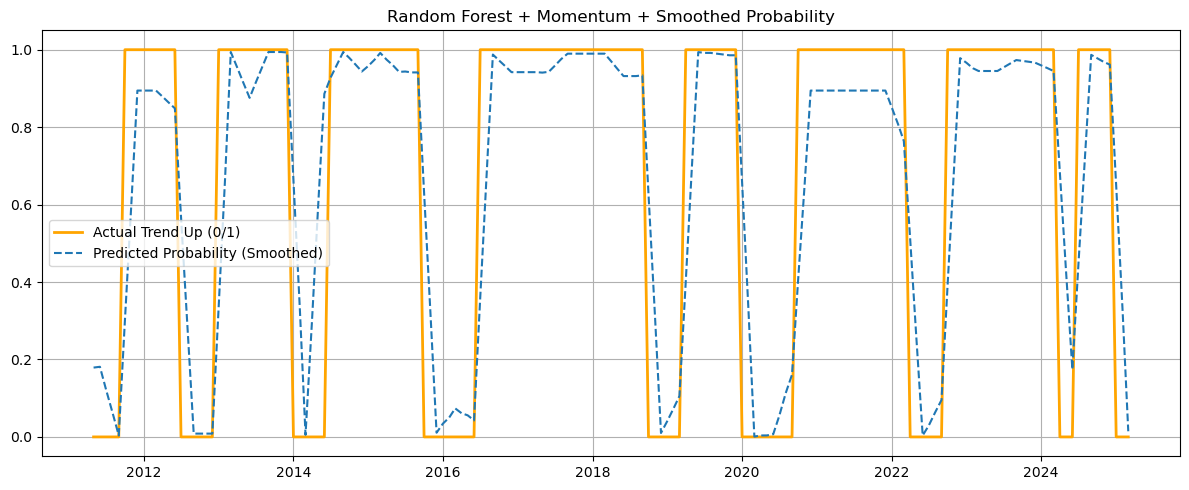

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
df_all['Gap_6M_before'] = df_all['Output_Gap'].shift(6)
df_all['Gap_6M_change'] = df_all['Output_Gap'] - df_all['Gap_6M_before']
df_all['Trend_Label'] = (df_all['Gap_6M_change'] > 0).astype(int)

df_all['OG_Mom_3M'] = df_all['Output_Gap'] - df_all['Output_Gap'].shift(3)
df_all['OG_Mom_6M'] = df_all['Output_Gap'] - df_all['Output_Gap'].shift(6)

X_cls = df_all[[
    '10Y_minus_6M_lag1',
    'M2_YoY_lag1',
    'OG_Mom_3M',
    'OG_Mom_6M'
]]
y_cls = df_all['Trend_Label']

# ==== date cleaning ====
df_cls = pd.concat([X_cls, y_cls], axis=1).dropna()
X_cls = df_cls.drop(columns='Trend_Label')
y_cls = df_cls['Trend_Label']

#split training/testing
split_idx = int(len(X_cls) * 0.6)
X_train, X_test = X_cls[:split_idx], X_cls[split_idx:]
y_train, y_test = y_cls[:split_idx], y_cls[split_idx:]
index_test = y_test.index

#training
clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=3,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)

#predicting
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]
y_prob_smooth = pd.Series(y_prob, index=index_test).rolling(3, min_periods=1).mean()

# ==== output ====
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

# ==== plot ====
plt.figure(figsize=(12, 5))
plt.plot(index_test, y_test.values, label='Actual Trend Up (0/1)', color='orange', linewidth=2)
plt.plot(index_test, y_prob_smooth, label='Predicted Probability (Smoothed)', linestyle='--')
plt.title('Random Forest + Momentum + Smoothed Probability')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:

df_etf = pd.read_excel("ETF list.xlsx", header=[0, 1])
df_etf.columns = [' '.join(col).strip() for col in df_etf.columns]

df_etf.head()

,Unnamed: 0_level_0 Dates,XLK US Equity PX_LAST,XLC US Equity PX_LAST,XLV US Equity PX_LAST,XLF US Equity PX_LAST,XLY US Equity PX_LAST,XLP US Equity PX_LAST,XLE US Equity PX_LAST,XLI US Equity PX_LAST,XLU US Equity PX_LAST,XLRE US Equity PX_LAST,XLB US Equity PX_LAST
0,32932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,33053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:

df_etf.rename(columns={"Unnamed: 0_level_0 Dates": "Date"}, inplace=True)
df_etf.head()

,Date,XLK US Equity PX_LAST,XLC US Equity PX_LAST,XLV US Equity PX_LAST,XLF US Equity PX_LAST,XLY US Equity PX_LAST,XLP US Equity PX_LAST,XLE US Equity PX_LAST,XLI US Equity PX_LAST,XLU US Equity PX_LAST,XLRE US Equity PX_LAST,XLB US Equity PX_LAST
0,32932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,33053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
if pd.api.types.is_numeric_dtype(df_etf["Date"]):
    df_etf["Date"] = pd.to_datetime(df_etf["Date"], origin="1899-12-30", unit="D")
else:
    df_etf["Date"] = pd.to_datetime(df_etf["Date"], errors="coerce")

df_etf.head()

,Date,XLK US Equity PX_LAST,XLC US Equity PX_LAST,XLV US Equity PX_LAST,XLF US Equity PX_LAST,XLY US Equity PX_LAST,XLP US Equity PX_LAST,XLE US Equity PX_LAST,XLI US Equity PX_LAST,XLU US Equity PX_LAST,XLRE US Equity PX_LAST,XLB US Equity PX_LAST
0,1990-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1990-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:

df_etf = df_etf[df_etf["Date"] > pd.to_datetime("1998-12-31")]


print(df_etf.head())

          Date  XLK US Equity PX_LAST  XLC US Equity PX_LAST  \
107 1999-01-29                37.8125                    NaN   
108 1999-02-26                34.0625                    NaN   
109 1999-03-31                36.5938                    NaN   
110 1999-04-30                36.8125                    NaN   
111 1999-05-31                36.9375                    NaN   

     XLV US Equity PX_LAST  XLF US Equity PX_LAST  XLY US Equity PX_LAST  \
107                27.2500                19.3615                27.4688   
108                27.2813                19.6660                27.2969   
109                28.0000                20.2497                28.5938   
110                29.0000                21.6707                29.3438   
111                28.1094                20.3639                28.0156   

     XLP US Equity PX_LAST  XLE US Equity PX_LAST  XLI US Equity PX_LAST  \
107                26.7969                21.8125                24.2969   
108   

In [38]:
df_etf["Date"] = pd.to_datetime(df_etf["Date"], errors="coerce")

df_etf["Date"] = df_etf["Date"] + pd.offsets.MonthEnd(1)

df_etf["Date"] = df_etf["Date"].apply(lambda x: x.replace(day=1) if pd.notna(x) else x)

df_etf = df_etf[df_etf["Date"].notna()]

print(df_etf)

          Date  XLK US Equity PX_LAST  XLC US Equity PX_LAST  \
107 1999-01-01                37.8125                    NaN   
108 1999-02-01                34.0625                    NaN   
109 1999-04-01                36.5938                    NaN   
110 1999-05-01                36.8125                    NaN   
111 1999-06-01                36.9375                    NaN   
..         ...                    ...                    ...   
414 2024-08-01               220.3300                  87.32   
415 2024-10-01               225.7600                  90.40   
416 2024-11-01               222.2400                  92.04   
417 2024-11-01               233.7300                  98.40   
418 2025-01-01               232.5200                  96.81   

     XLV US Equity PX_LAST  XLF US Equity PX_LAST  XLY US Equity PX_LAST  \
107                27.2500                19.3615                27.4688   
108                27.2813                19.6660                27.2969   
109

In [40]:
df_etf = df_etf[df_etf["Date"].notna()]

df_etf.set_index("Date", inplace=True)

df_etf = df_etf[df_etf.index.isin(df_monthly.index)]

combined = df_monthly.join(df_etf, how="inner")
print(combined)

            Actual_GDP  Potential_GDP  Output_Gap  XLK US Equity PX_LAST  \
1999-01-01   13315.597    13074.75048    1.842074                37.8125   
1999-02-01   13315.597    13074.75048    1.842074                34.0625   
1999-04-01   13426.748    13215.68444    1.597069                36.5938   
1999-05-01   13426.748    13215.68444    1.597069                36.8125   
1999-06-01   13426.748    13215.68444    1.597069                36.9375   
...                ...            ...         ...                    ...   
2024-08-01   23400.294    22981.32000    1.823107               220.3300   
2024-10-01   23542.349    23113.34000    1.856110               225.7600   
2024-11-01   23542.349    23113.34000    1.856110               222.2400   
2024-11-01   23542.349    23113.34000    1.856110               233.7300   
2025-01-01   23528.047    23243.22000    1.225420               232.5200   

            XLC US Equity PX_LAST  XLV US Equity PX_LAST  \
1999-01-01                 

In [42]:
# 1. split Output Gap 
positive_gap = combined[combined["Output_Gap"] > 0]
negative_gap = combined[combined["Output_Gap"] < 0]

# 计算 Sharpe Ratio（平均收益 / 标准差）
sharpe_pos = positive_gap.iloc[:, 3:].pct_change().mean() / positive_gap.iloc[:, 3:].pct_change().std()
sharpe_neg = negative_gap.iloc[:, 3:].pct_change().mean() / negative_gap.iloc[:, 3:].pct_change().std()

# 取前3名表现最好 ETF
top_sharpe_pos = sharpe_pos.sort_values(ascending=False).head(3)
top_sharpe_neg = sharpe_neg.sort_values(ascending=False).head(3)

# 打印结果
print("📈 Output Gap 为正时 Sharpe 表现最好的 ETF：")
print(top_sharpe_pos)

print("\n📉 Output Gap 为负时 Sharpe 表现最好的 ETF：")
print(top_sharpe_neg)

📈 Output Gap 为正时 Sharpe 表现最好的 ETF：
XLC US Equity PX_LAST    0.194057
XLE US Equity PX_LAST    0.178557
XLB US Equity PX_LAST    0.166869
dtype: float64

📉 Output Gap 为负时 Sharpe 表现最好的 ETF：
XLC US Equity PX_LAST    0.330106
XLY US Equity PX_LAST    0.208117
XLV US Equity PX_LAST    0.201429
dtype: float64


In [44]:
import numpy as np
window = 6  
etf_cols = [col for col in combined.columns if col.endswith("PX_LAST")]


labels = []
for i in range(len(combined) - window + 1):
    gap_seg = combined['Output_Gap'].iloc[i:i+window]
    if gap_seg.is_monotonic_increasing:
        labels.append(1)
    elif gap_seg.is_monotonic_decreasing:
        labels.append(-1)
    else:
        labels.append(0)
combined['Gap_Trend_6M'] = [np.nan]*(window-1) + labels

# ===== calculate monthly return =====
returns = combined[etf_cols].pct_change()
combined[etf_cols] = returns

# ===== average return during upward/downward trend =====
rising = combined[combined['Gap_Trend_6M'] == 1]
falling = combined[combined['Gap_Trend_6M'] == -1]

rising_perf = rising[etf_cols].mean().sort_values(ascending=False)
falling_perf = falling[etf_cols].mean().sort_values(ascending=False)

# ===== output =====
print(" Top 3 performer during expasion ETF：")
print(rising_perf.head(3))

print(" Top 3 performer during recession ETF：")
print(falling_perf.head(3))

 Top 3 performer during expasion ETF：
XLK US Equity PX_LAST    0.018195
XLC US Equity PX_LAST    0.017108
XLY US Equity PX_LAST    0.015124
dtype: float64
 Top 3 performer during recession ETF：
XLV US Equity PX_LAST   -0.000341
XLY US Equity PX_LAST   -0.000990
XLB US Equity PX_LAST   -0.001295
dtype: float64


In [46]:
print(combined.columns)

Index(['Actual_GDP', 'Potential_GDP', 'Output_Gap', 'XLK US Equity PX_LAST',
       'XLC US Equity PX_LAST', 'XLV US Equity PX_LAST',
       'XLF US Equity PX_LAST', 'XLY US Equity PX_LAST',
       'XLP US Equity PX_LAST', 'XLE US Equity PX_LAST',
       'XLI US Equity PX_LAST', 'XLU US Equity PX_LAST',
       'XLRE US Equity PX_LAST', 'XLB US Equity PX_LAST', 'Gap_Trend_6M'],
      dtype='object')


In [48]:
combined["Smoothed_Proba"] = y_prob_smooth
print(combined)

            Actual_GDP  Potential_GDP  Output_Gap  XLK US Equity PX_LAST  \
1999-01-01   13315.597    13074.75048    1.842074                    NaN   
1999-02-01   13315.597    13074.75048    1.842074              -0.099174   
1999-04-01   13426.748    13215.68444    1.597069               0.074313   
1999-05-01   13426.748    13215.68444    1.597069               0.005976   
1999-06-01   13426.748    13215.68444    1.597069               0.003396   
...                ...            ...         ...                    ...   
2024-08-01   23400.294    22981.32000    1.823107               0.006993   
2024-10-01   23542.349    23113.34000    1.856110               0.024645   
2024-11-01   23542.349    23113.34000    1.856110              -0.015592   
2024-11-01   23542.349    23113.34000    1.856110               0.051701   
2025-01-01   23528.047    23243.22000    1.225420              -0.005177   

            XLC US Equity PX_LAST  XLV US Equity PX_LAST  \
1999-01-01                 

In [50]:
print(combined.head())

            Actual_GDP  Potential_GDP  Output_Gap  XLK US Equity PX_LAST  \
1999-01-01   13315.597    13074.75048    1.842074                    NaN   
1999-02-01   13315.597    13074.75048    1.842074              -0.099174   
1999-04-01   13426.748    13215.68444    1.597069               0.074313   
1999-05-01   13426.748    13215.68444    1.597069               0.005976   
1999-06-01   13426.748    13215.68444    1.597069               0.003396   

            XLC US Equity PX_LAST  XLV US Equity PX_LAST  \
1999-01-01                    NaN                    NaN   
1999-02-01                    NaN               0.001149   
1999-04-01                    NaN               0.026344   
1999-05-01                    NaN               0.035714   
1999-06-01                    NaN              -0.030710   

            XLF US Equity PX_LAST  XLY US Equity PX_LAST  \
1999-01-01                    NaN                    NaN   
1999-02-01               0.015727              -0.006258   
19